In [4]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from lasagne.layers import DenseLayer, InputLayer, DropoutLayer, Conv2DLayer, MaxPool2DLayer, get_all_params
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline

In [7]:
home_dir = '/Users/babasarala/Desktop'

In [8]:
def load_mnist(path):
    X = []
    y = []
    with open(path, 'rb') as f:
        next(f) # skip header
        for line in f:
            yi, xi = line.split(',', 1)
            y.append(yi)
            X.append(xi.split(','))
        
        # Theano works with fp32 precision
        X = np.array(X).astype(np.float32)
        y = np.array(y).astype(np.int32)
        
        # apply some very simple normalization to the data
        X -= X.mean()
        X /= X.std()
        
        # For convolutional layers, the default shape of data is bc01,
        # i.e. batch size x color channels x image dimension 1 x image dimension 2.
        # Therefore, we reshape the X data to -1, 1, 28, 28.
        X = X.reshape(
            -1,  # number of samples, -1 makes it so that this number is determined automatically
            1,   # 1 color channel, since images are only black and white
            28,  # first image dimension (vertical)
            28,  # second image dimension (horizontal)
        )

    return X, y

In [9]:
path = os.path.join(os.path.expanduser('~'), '%s/lasagne_nns/data/train.csv'%home_dir)

In [10]:
X, y = load_mnist(path)

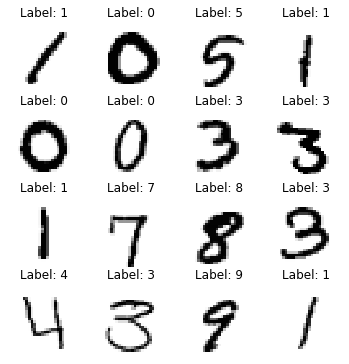

In [11]:
figs, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(-X[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("Label: {}".format(y[i + 4 * j]))
        axes[i, j].axis('off')

In [12]:
X.shape

(42000, 1, 28, 28)

In [14]:
layers0 = [
    # layer dealing with the input data
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),
    
    # first stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),
    
    # second stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),
    
    # two dense layers with dropout
    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units':64}),
    
    # output layer
    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax})
]

In [15]:
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    
    # get the layers' weights, but only those that should be regularized (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    
    # sum of squared weights
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    
    return losses

In [16]:
net0 = NeuralNet(
        layers=layers0,
        max_epochs=10,

        update=adam,
        update_learning_rate=0.0002,

        objective=regularization_objective,
        objective_lambda2=0.0025,

        train_split=TrainSplit(eval_size=0.25),
        verbose=1)

In [ ]:
net0.

In [27]:
net0.fit(X, y)

# Neural Network with 753610 learnable parameters

## Layer information

  #  name         size
---  -----------  --------
  0  input0       1x28x28
  1  conv2d1      96x24x24
  2  conv2d2      96x22x22
  3  conv2d3      96x20x20
  4  conv2d4      96x18x18
  5  conv2d5      96x16x16
  6  maxpool2d6   96x8x8
  7  conv2d7      128x6x6
  8  conv2d8      128x4x4
  9  conv2d9      128x2x2
 10  maxpool2d10  128x1x1
 11  dense11      64
 12  dropout12    64
 13  dense13      64
 14  dense14      10



NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10da90e10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10da90cd0>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 5, 'num_filters': 96}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'num_filters': 96}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'fil...ne.layers.dense.DenseLayer'>, {'num_units': 10, 'nonlinearity': <function softmax at 0x10d648938>})],
     loss=None, max_epochs=10, more_params={},
     objective=<function regularization_objective at 0x10eb2a398>,
     objective_lambda2=0.0025,
     objective_loss_function=<function categorical_crossentropy at 0x10d7e00c8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x10eb0db48>],
     on

In [31]:
net0.get_all_layers()[1]